In [60]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils.vis import *
from my_utils import models
from my_utils.utils import check_accuracy
from my_utils.data.dataset import make_dataset, MyDataset_actions, MyDataset_positions, raw_png_processor, raw_video_processor
from my_utils.data.loader import load_frames
from my_utils.data.preprocess import sub_mean, reduce

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:4" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:4 now!


In [57]:
dm = raw_png_processor(dataset_name='variety')

In [58]:
dm.check_data(mode='train')

100%|█████████████████████████████████████████████████████| 800/800 [00:14<00:00, 56.19it/s]

{'Clap': 160, 'Crouch to Stand': 160, 'Dance': 160, 'Idle': 160, 'Jump': 160}
floor	 {'white_tiling': 200, 'grey_tiling': 200, 'wooden_floor_1': 200, 'wooden_floor_2': 200}
rot_num	 [200, 200, 200, 200]
pos_num	 [160, 160, 160, 160, 160]


In [59]:
dm.build_dataset()

5 classes in total: ['Clap', 'Crouch to Stand', 'Dance', 'Idle', 'Jump']


100%|█████████████████████████████████████████████████████| 800/800 [18:25<00:00,  1.38s/it]


In [53]:
png_abs_dir = '/mnt/cfs/wangyh/blender/blank_wall/output_random/Clapping/grey_tiling_r1_p0_Jody_05-18_14:14'
frames = load_frames(png_abs_dir, frame_range=(0, 5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


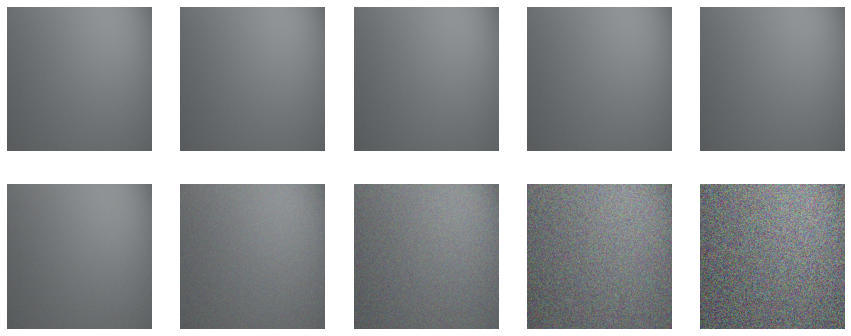

In [54]:
plt.figure(figsize=(15, 6))
noise_factor = [0.01, 0.03, 0.05, 0.1, 0.15]
for i, pic in enumerate(frames.cpu()[:,:,:,:3]):
    pic = pic.type(torch.int)
    plt.subplot(2,5,i+1)
    plt.imshow(pic)
    plt.axis('off')

    noisy_pic = pic + 255 * noise_factor[i] * torch.randn_like(pic, dtype=torch.float)
    noisy_pic = noisy_pic.type(torch.int)
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_pic)
    plt.axis('off')


In [61]:
vp = raw_video_processor()

In [65]:
vp.build_dataset()

Input buffer exhausted before END element found
Input buffer exhausted before END element found
decode_band_types: Input buffer exhausted before END element found
decode_band_types: Input buffer exhausted before END element found
Input buffer exhausted before END element found
decode_band_types: Input buffer exhausted before END element found


In [94]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 64)),
        # transforms.Normalize(mean, std)
    # transforms.ColorJitter(brightness=.1, hue=.1)
])

In [95]:
dataset = MyDataset_actions(
    dataset_root='/mnt/cfs/wangyh/blender/blank_wall/datasets/video_test/',
    # raw_data_root='/mnt/cfs/wangyh/blender/blank_wall/output_random/',
    reduce_mode='W',
    transform=T
)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
len(loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

['Clapping', 'Flair', 'Hip Hop Dancing', 'Jump', 'Jumping Jacks', 'Mma Kick', 'Rumba Dancing', 'Standing', 'Sweep Fall', 'Waving']


24

In [85]:
for i in range(24):
    print(dataset[0][0].shape == torch.Size([3, 256, 64]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


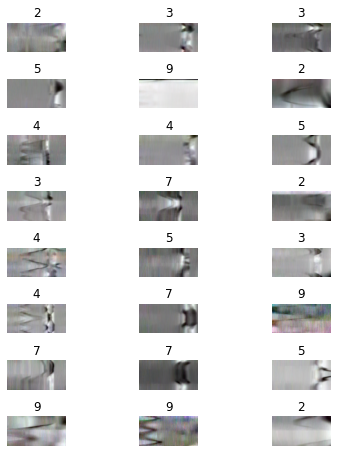

In [96]:
grid_vis(loader, row_num=8, multiply=5)

In [109]:
model = models.NLOS_Conv(num_classes=10, depths=(4,1), dims=(16,32), kernel_size=7).to(device)
checkpoint = torch.load('/home/wangyh/01-Projects/01-NLOS/test_runs/2022_05_21_19_06_34/checkpoints/best.pth')
new_state_dict = {k.replace('module.',''):v for k,v in checkpoint['model'].items()}
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [110]:
m = check_accuracy(model, loader)

1it [00:00,  2.75it/s]

Test accuracy is : 16.67%	Infer time: 0.36664581298828125


In [108]:
checkpoint['best_val_acc']

tensor(0.8927, device='cuda:0')

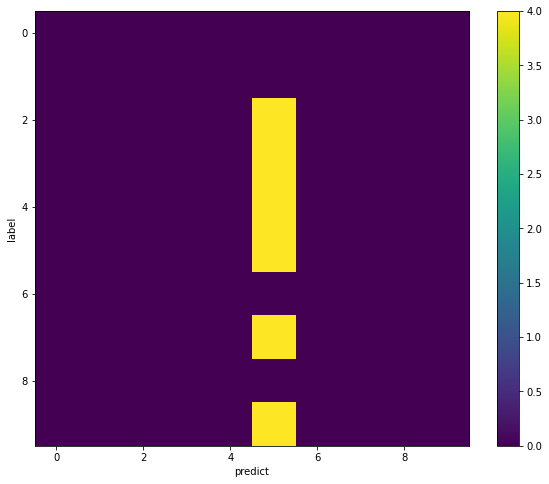

In [111]:
# plt.figure(figsize=np.array(m.shape) * 1.5)
plt.imshow(m, cmap='viridis')
plt.ylabel('label')
plt.xlabel('predict')
plt.colorbar()

In [69]:
inputs, labels = next(iter(unseen_loader))
print(inputs.shape)
print(labels)

torch.Size([40, 3, 128, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4])


In [70]:
model.eval()
scores = model(inputs.to(device))
preds = scores.argmax(dim=1)
print(preds)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:1')
